In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
import collections
from io import StringIO
!pip install pydotplus
import sklearn
import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
!conda install --yes graphviz
from IPython import display

Solving environment: done

# All requested packages already installed.



In [3]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [4]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [5]:
#training data

df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_target = df_train

In [6]:
#test data
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [7]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Alcoholic_beverage_yes,Money_spent_lots,Money_spent_little,Looks_handsome,Eloquence_high,Looks_repulsive,Alcoholic_beverage_no,Eloquence_average
0,1,1,0,1,1,0,0,0
1,1,0,1,1,0,0,0,0
2,0,1,0,1,0,0,1,1
3,0,0,1,0,0,1,1,1
4,1,1,0,0,0,1,0,0
5,1,1,0,0,1,1,0,0
6,1,1,0,1,0,0,0,1


In [8]:
df_test

,Alcoholic_beverage_yes,Money_spent_lots,Money_spent_little,Looks_handsome,Eloquence_high,Looks_repulsive,Alcoholic_beverage_no,Eloquence_average
0,0,1,0,1,0,0,1,1
1,1,0,1,1,1,0,0,0
2,1,1,0,0,0,1,0,1


In [9]:
#1. What is the entropy of the initial system? 
# By system states, we mean values of the binary feature “Will_go” - 0 or 1 - two states in total.

In [10]:
#S = -sum_{i}(p_i * log_2(p_i))
p_0 = 4/7
p_1 = 3/7
S = -p_0 * np.log2(p_0) - p_1 * np.log2(p_1)
S = round(S, 3)
print('Entropy of the inital system is ' + str(S))

Entropy of the inital system is 0.985


In [11]:
#2. Let’s split the data by the feature “Looks_handsome”. What is the entropy 
# of the left group - the one with “Looks_handsome”. What is the entropy 
# in the opposite group? What is the information gain (IG) if we consider such a split?

In [12]:
df_target

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [13]:
#devide into two groups
left_group = df_target[df_target['Looks_handsome'] == 1]
right_group = df_target[df_target['Looks_handsome'] == 0]

In [14]:
left_group

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [15]:
right_group

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1


In [16]:
#calculate entropy and IG
#IG = S_0 - sum_i({N_i/N} * S_i)
S_l = round(-(3/4) * np.log2(3/4) - 1/4 * np.log2(1/4), 3)
S_r = round(-(1/3) * np.log2(1/3) - 2/3 * np.log2(2/3), 3)
IG = round(S - (4/7)* S_l - (3/7) * S_r, 3)
print(' Left group Entropy: ' +  str(S_l) + '\n Right group Entropy: ' + str(S_r) + '\n Information gain: ' + str(IG))

 Left group Entropy: 0.811
 Right group Entropy: 0.918
 Information gain: 0.128


In [17]:
#Train a decision tree using sklearn on the training data

In [48]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=17)
clf_tree.fit(df_train, y)

DecisionTreeClassifier(criterion='entropy', random_state=17)

In [51]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = sklearn.tree.export_graphviz(
        tree, feature_names=df_train.columns, filled=True, class_names=["Won't go", "Will go"]
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

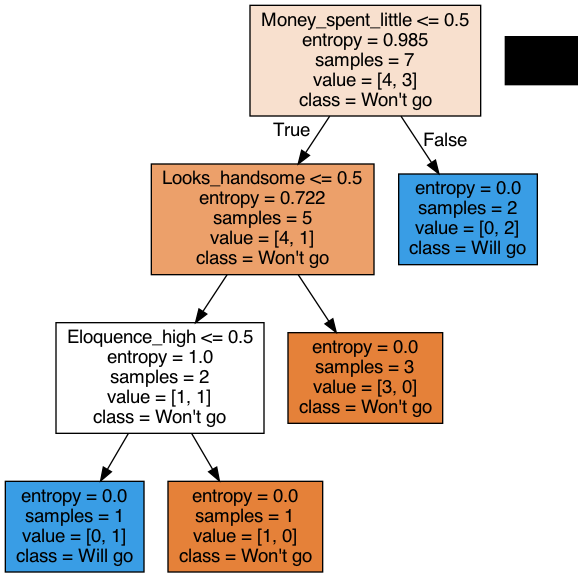

In [52]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=df_train.columns,
    png_file_to_save="topic3_decision_tree1.png",
)
display.Image("topic3_decision_tree1.png")

In [66]:
#Functions for calculating entropy and information gain for list of balls (0 for first-type balls and 1 for another)

In [67]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [68]:
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [69]:
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

In [70]:
balls_left, balls_right

([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0])

In [71]:
#Implement a function to calculate the Shannon Entropy

In [114]:
def entropy(a_list):
    distinct_val = set(a_list)
    S = 0
    for val in distinct_val: 
        number_of_val = len(list(filter(lambda x: x==val, a_list)))
        S-= (number_of_val/len(a_list)) * np.log2(number_of_val/len(a_list))
    return round(S, 3) 

In [115]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.993
0.961
0.592
2.585


In [116]:
#3. What is the entropy of the state given by the list balls_left? 
print(entropy(balls_left))

0.961


In [204]:
#4. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?
print(entropy([1, 2, 3, 4, 5, 6]))

2.585


In [205]:
#Implement a function to calculate the Information Gain

In [206]:
# information gain calculation
#root - initial data
def information_gain(root, left, right):
    IG = entropy(root)
    IG -= entropy(left) * (len(left)/len(root))
    IG -= entropy(right) * (len(right)/len(root))
    return round(IG, 3)

In [277]:
#5. What is the information gain of splitting the initial dataset into balls_left and balls_right?
print(information_gain(balls,balls_left, balls_right))

0.161


In [208]:
#The “Adult” dataset

In [209]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")

In [210]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [211]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [212]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [213]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

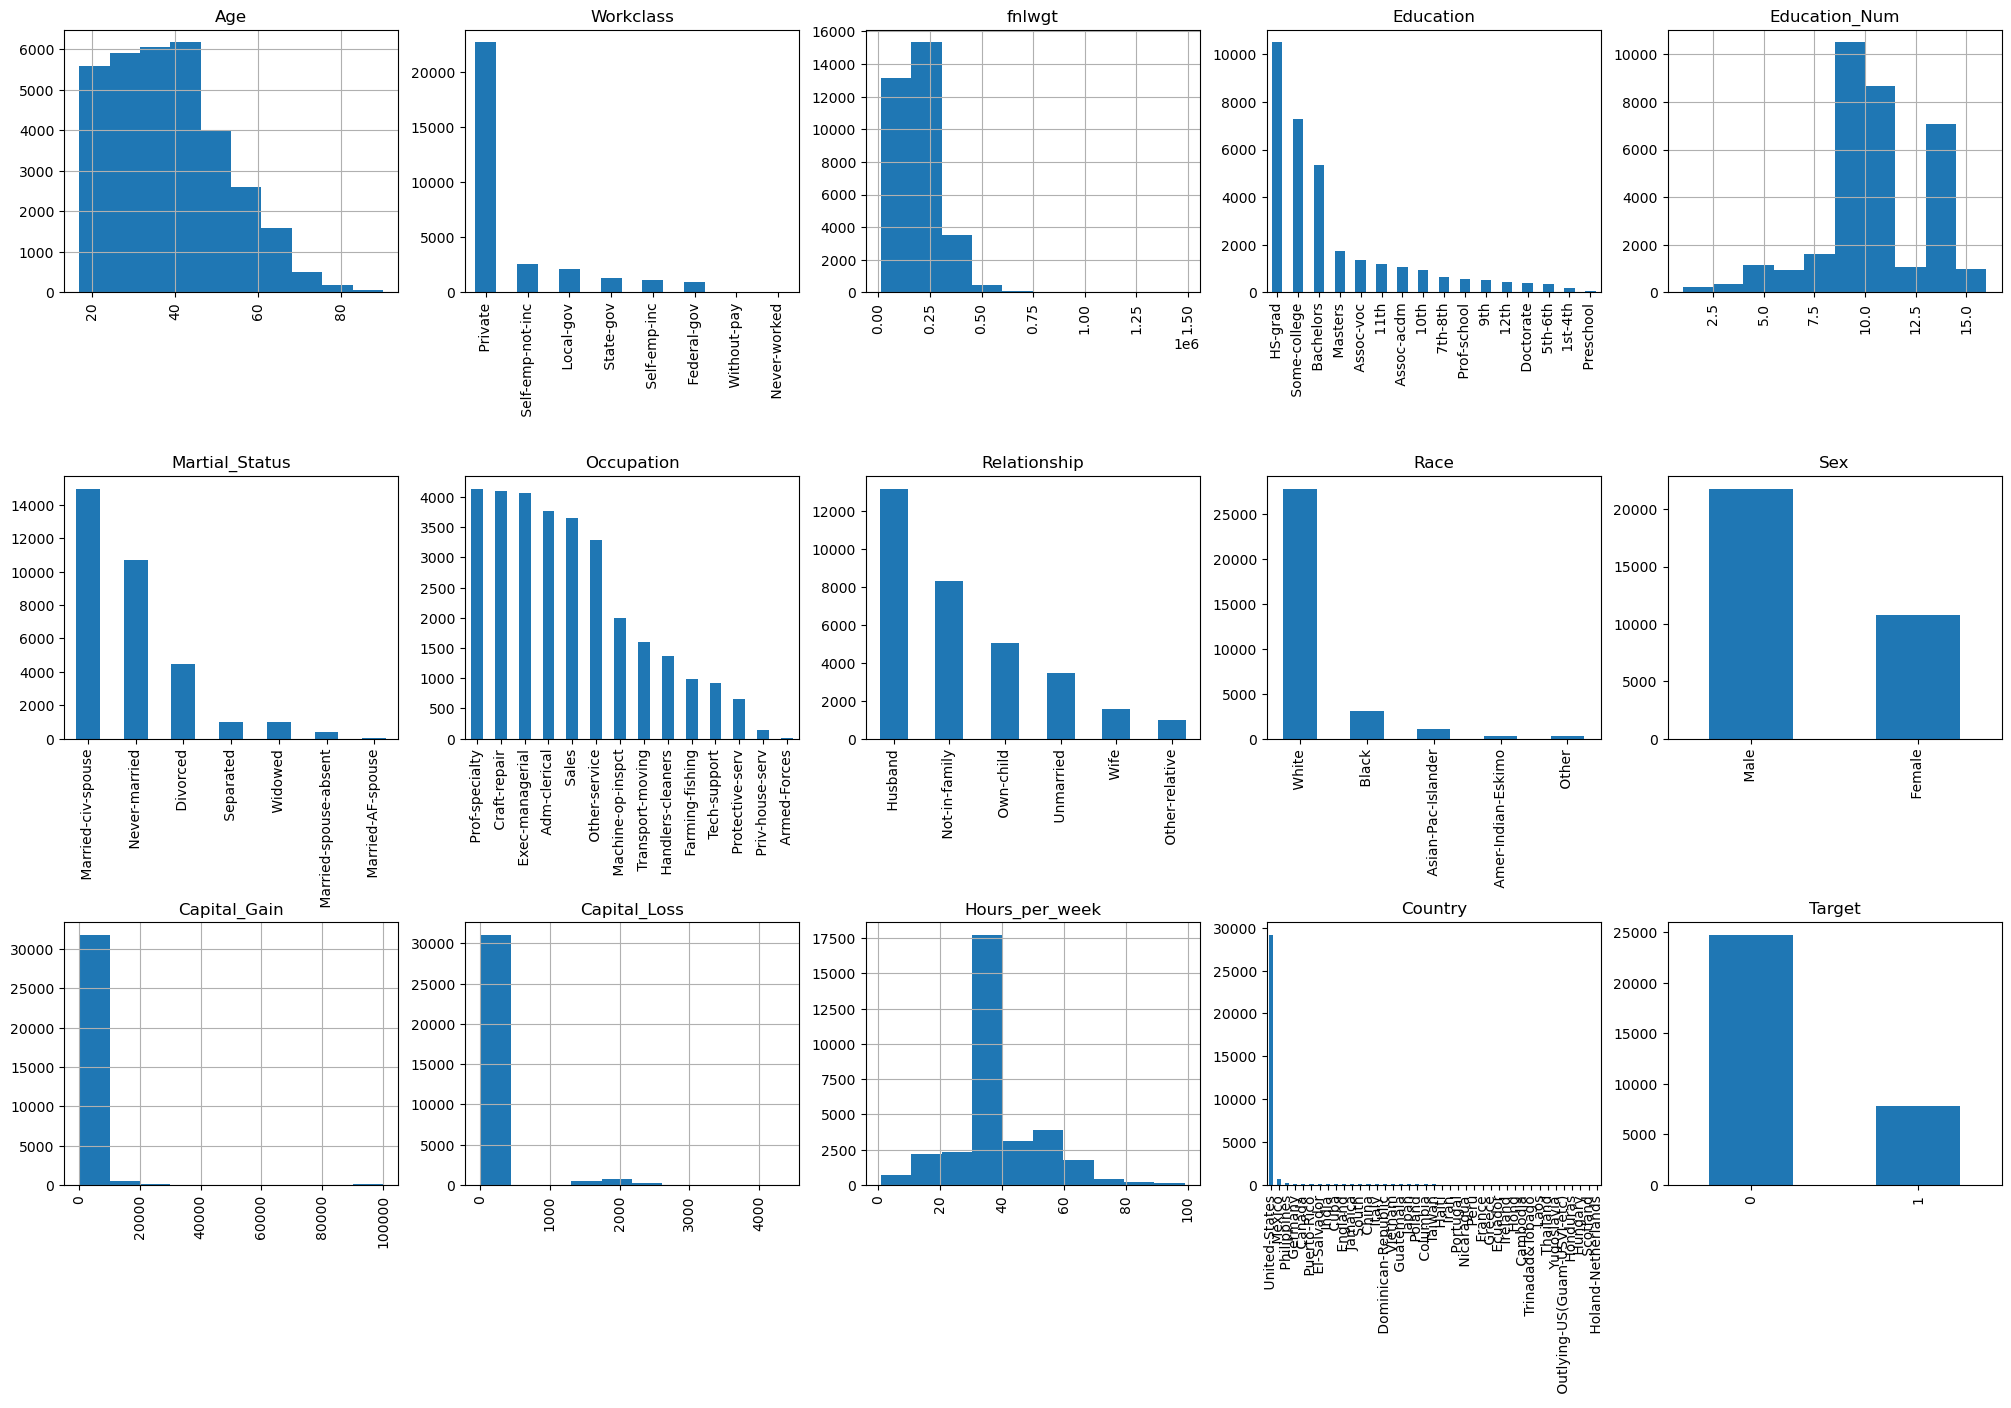

In [215]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

In [216]:
#checking data types 
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [217]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [218]:
data_test["Age"] = data_test["Age"].astype(int)
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

In [219]:
#Save targets separately
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

In [220]:
#Fill in missing data for continuous features with their median values, for categorical features with their mode
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [221]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [222]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [223]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [224]:
#We’ll dummy code some categorical features: Workclass, Education, Martial_Status, 
#Occupation, Relationship, Race, Sex, Country. It can be done via pandas method get_dummies
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [225]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [226]:
data_train.shape, data_test.shape

((32561, 105), (16281, 104))

In [227]:
#There is no Holland in the test data. Create new zero-valued feature
data_test["Country_ Holand-Netherlands"] = 0

In [228]:
set(data_train.columns) - set(data_test.columns)

set()

In [229]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [230]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [231]:
X_train = data_train
X_test = data_test

In [244]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [245]:
#Decision tree without parameter tuning

In [246]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [256]:
#6. What is the test set accuracy of a decision tree with maximum tree depth of 3 and random_state = 17?
tree_pred = tree.predict(X_test[X_train.columns])
round(accuracy_score(y_test, tree_pred), 3)

0.845

In [257]:
#Decision tree with parameter tuning

In [266]:
tree_params = {"max_depth": range(2, 11), 'random_state': range(10, 20)}
locally_best_tree = GridSearchCV(tree, tree_params, cv=5)
locally_best_tree.fit(X_train, y_train)
locally_best_tree.best_params_

{'max_depth': 9, 'random_state': 16}

In [267]:
round(accuracy_score(y_test, locally_best_tree.predict(X_test[X_train.columns])), 3)

0.858

In [270]:
# Random forest without parameter tuning

In [271]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [273]:
round(accuracy_score(y_test, rf.predict(X_test[X_train.columns])), 3)

0.853

In [274]:
#Random forest with parameter tuning

In [275]:
%%time
forest_params = {"max_depth": range(10, 21), "max_features": range(5, 105, 20)}
locally_best_forest = GridSearchCV(rf, forest_params, cv=5, n_jobs=-1, verbose=True)
locally_best_forest.fit(X_train, y_train)
locally_best_forest.best_params_

Fitting 5 folds for each of 55 candidates, totalling 275 fits
CPU times: user 6.43 s, sys: 300 ms, total: 6.73 s
Wall time: 9min 42s


{'max_depth': 19, 'max_features': 25}

In [276]:
round(accuracy_score(y_test, locally_best_forest.predict(X_test[X_train.columns])), 3)

0.864